# Deploying an Object Detection Model

This notebook is an adaptation of the content from [deeplearning.ai](https://github.com/https-deeplearning-ai/machine-learning-engineering-for-production-public)
We use a pretrained YOLO model - [`YOLOV3`](https://pjreddie.com/darknet/yolo/) to detect common objects in images.

The sequence of steps/tasks twe execute are:

1. Inspect the image data set used for object detection
2. Take a look at the model itself
3. Deploy the model using [`fastAPI`](https://fastapi.tiangolo.com/)

In [15]:
import io
import uvicorn
import nest_asyncio
import os
import cv2

import numpy as np
import cvlib as cv

from enum import Enum

from fastapi import FastAPI, UploadFile, File, HTTPException
from fastapi.responses import StreamingResponse
from IPython.display import Image, display

## Object Detection with YOLOV3

### Inspecting the images


Let's take a look at the images that will be passed to the YOLOV3 model. This will bring insight on what type of common objects are present for detection. These images are part of the [`ImageNet`](http://www.image-net.org/index) dataset.


Displaying image: apple.jpg


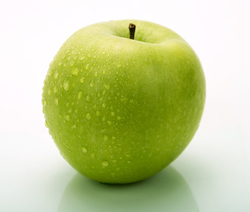


Displaying image: clock.jpg


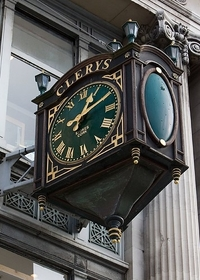


Displaying image: oranges.jpg


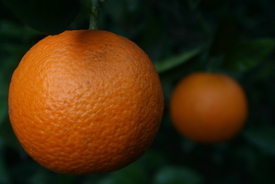


Displaying image: car.jpg


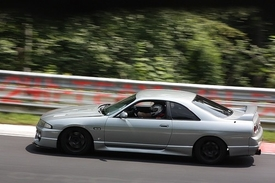

In [2]:
# Some example images
image_files = [
    'apple.jpg',
    'clock.jpg',
    'oranges.jpg',
    'car.jpg'
]

for image_file in image_files:
    print(f"\nDisplaying image: {image_file}")
    display(Image(filename=f"images/{image_file}"))

### Overview of the model

The predictions for these images will be handled using [`cvlib`](https://www.cvlib.net/), which is a very simple but powerful library for object detection that is fueled by [`OpenCV`](https://docs.opencv.org/4.5.1/) and [`Tensorflow`](https://www.tensorflow.org/).

### Creating the detect_and_draw_box function

Before using the object detection model, create a directory where you can store the resulting images:


In [4]:
dir_name = "images_with_boxes"

if not os.path.exists(dir_name):
    os.mkdir(dir_name)

Let's define the `detect_and_draw_box` function which takes as input arguments: the **filename** of a file on your system, a **model**, and a **confidence level**. With these inputs, it detects common objects in the image and saves a new image displaying the bounding boxes alongside the detected object.

You might ask yourself why does this function receive the model as an input argument? What models are there to choose from? The answer is that `detect_common_objects` uses the `yolov3` model by default.  However, there is another option available that is much tinier and requires less computational power. 

It is the `yolov3-tiny` version. As the model name indicates, this model is designed for constrained environments that cannot store big models. With this comes a natural tradeoff: the results are less accurate than the full model. However, it still works pretty well. Going forward, we recommend you stick to it since it is a lot smaller than the regular `yolov3` and downloading its pretrained weights takes less time.

The model output is a vector of probabilities for the presence of different objects on the image. The last input argument, confidence level, determines the threshold that the probability needs to surpass to report that a given object is detected on the supplied image. By default, `detect_common_objects` uses a value of 0.5 for this.

In [9]:
def detect_and_draw_box(filename, model="yolov3-tiny", confidence=0.5):
    """Detects common objects on an image and creates a new image with bounding boxes.

    Args:
        filename (str): Filename of the image.
        model (str): Either "yolov3" or "yolov3-tiny". Defaults to "yolov3-tiny".
        confidence (float, optional): Desired confidence level. Defaults to 0.5.
    """
    
    # Images are stored under the images/ directory
    img_filepath = f'images/{filename}'
    
    # Read the image into a numpy array
    img = cv2.imread(img_filepath)
    
    # Perform the object detection
    bbox, label, conf = cv.detect_common_objects(img, confidence=confidence, model=model)
    
    # Print current image's filename
    print(f"========================\nImage processed: {filename}\n")
    
    # Print detected objects with confidence level
    for l, c in zip(label, conf):
        print(f"Detected object: {l} with confidence level of {c}\n")
    
    # Create a new image that includes the bounding boxes
    output_image = cv.object_detection.draw_bbox(img, bbox, label, conf)
    
    # Save the image in the directory images_with_boxes
    cv2.imwrite(f'images_with_boxes/{filename}', output_image)
    
    # Display the image with bounding boxes
    display(Image(f'images_with_boxes/{filename}'))

Let's try it out for the example images.

Image processed: apple.jpg

Detected object: apple with confidence level of 0.571720540523529



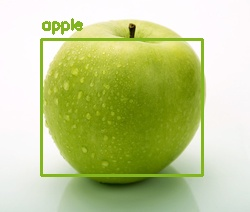

Image processed: clock.jpg

Detected object: clock with confidence level of 0.9683184623718262



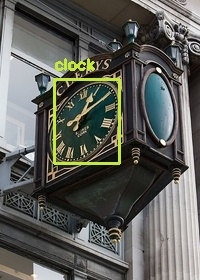

Image processed: oranges.jpg

Detected object: orange with confidence level of 0.6185590624809265

Detected object: orange with confidence level of 0.5561691522598267



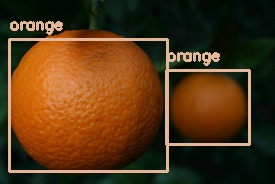

Image processed: car.jpg

Detected object: car with confidence level of 0.6325409412384033



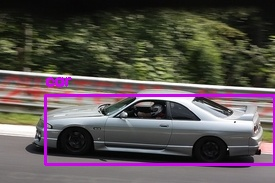

In [10]:
for image_file in image_files:
    detect_and_draw_box(image_file)

## Changing the confidence level

Looks like the object detection went fairly well. Let's try it out on a more difficult image containing several objects:

Image processed: fruits.jpg

Detected object: apple with confidence level of 0.5818483829498291

Detected object: orange with confidence level of 0.5346482992172241

Detected object: orange with confidence level of 0.515099287033081



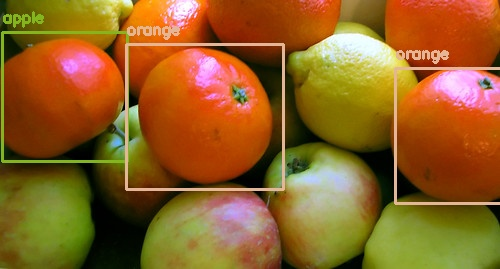

In [11]:
detect_and_draw_box("fruits.jpg")

The **model failed to detect** several fruits and **misclassified** an orange as an apple. This might seem strange since it was able to detect one apple before, so one might think the model has a fair representation on how an apple looks like.

One possibility is that the model **did** detect the other fruits but with a confidence level lower than 0.5. Let's test if  this is a valid hypothesis:

Image processed: fruits.jpg

Detected object: apple with confidence level of 0.5818483829498291

Detected object: orange with confidence level of 0.5346482992172241

Detected object: orange with confidence level of 0.515099287033081

Detected object: apple with confidence level of 0.34759876132011414

Detected object: orange with confidence level of 0.32876095175743103

Detected object: apple with confidence level of 0.31244680285453796

Detected object: orange with confidence level of 0.2798606753349304

Detected object: orange with confidence level of 0.2749978303909302

Detected object: apple with confidence level of 0.2744506895542145

Detected object: orange with confidence level of 0.21419063210487366



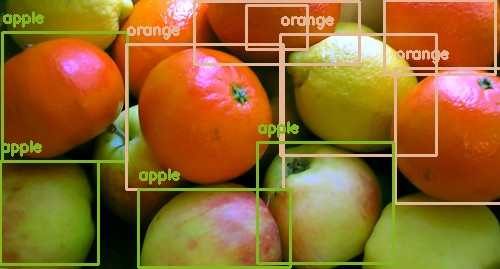

In [12]:
detect_and_draw_box("fruits.jpg", confidence=0.2)

By lowering the confidence level the model successfully detects most of the fruits. However, in order to correctly detect the objects present, we had to  set the confidence level really low. In general, you should be careful when decreasing or increasing these kinds of parameters, as changing them might yield undesired results.

As for this concrete example when an orange was misclassified as an apple, it serves as a reminder that these models are not perfect and this should be considered when using them for tasks in production.

## Deploying the model using fastAPI


### Placing your object detection model in a server

Now that you know how the model works it is time for you to deploy it! Aren't you excited? :)

Before diving into deployment, let's quickly recap some important concepts and how they translate to `fastAPI`. Let's also create a directory to store the images that are uploaded to the server.


In [13]:
dir_name = "images_uploaded"
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

### Some concept clarifications

#### Client-Server model

When talking about **deploying**, what is usually meant is to put all of the software required for predicting in a `server`. By doing this, a `client` can interact with the model by sending `requests` to the server. 

This client-server interaction is out of the scope of this notebook but there are a lot of resources on the internet that you can use to understand it better.

The important thing you need to focus on, is that the Machine Learning model lives in a server waiting for clients to submit prediction requests. The client should provide the required information that the model needs in order to make a prediction. Keep in mind that it is common to batch many predictions in a single request. The server will use the information provided to return predictions to the client, who can then use them at their leisure.

Let's get started by creating an instance of the `FastAPI` class:

```python
app = FastAPI()
```

The next step is using this instance to create endpoints that will handle the logic for predicting (more on this next). Once all the code is in place to run the server you only need to use the command:

```python
uvicorn.run(app)
```

Your API is coded using fastAPI but the serving is done using [`uvicorn`](https://www.uvicorn.org/), which is a really fast Asynchronous Server Gateway Interface (ASGI) implementation. Both technologies are closely interconnected and you don't need to understand the implementation details. Knowing that uvicorn handles the serving is sufficient for the purpose of this lab.

#### Endpoints

You can host multiple Machine Learning models on the same server. For this to work, you can assign a different `endpoint` to each model so you always know what model is being used. An endpoint is represented by a pattern in the `URL`. For example, if you have a website called `myawesomemodel.com` you could have three different models in the following endpoints:

- `myawesomemodel.com/count-cars/`
- `myawesomemodel.com/count-apples/`
- `myawesomemodel.com/count-plants/`

Each model would do what the name pattern suggests.

In fastAPI you define an endpoint by creating a function that will handle all of the logic for that endpoint and [decorating](https://www.python.org/dev/peps/pep-0318/) it with a function that contains information on the HTTP method allowed (more on this next) and the pattern in the URL that it will use.

The following example shows how to allow a HTTP GET request for the endpoint "/my-endpoint":

```python
@app.get("/my-endpoint")
def handle_endpoint():
    ...
    ...
```


#### HTTP Requests

The client and the server communicate with each other through a protocol called `HTTP`. The key concept here is that this communication between client and server uses some verbs to denote common actions. Two very common verbs are:

- `GET` -> Retrieves information from the server.
- `POST` -> Provides information to the server, which it uses to respond.

If your client does a `GET request` to an endpoint of a server you will get some information from this endpoint without the need to provide additional information. In the case of a `POST request` you are explicitly telling the server that you will provide some information for it that must be processed in some way.

Interactions with Machine Learning models living on endpoints are usually done via a `POST request` since you need to provide the information that is required to compute a prediction.

Let's take a look at a POST request:

```python
@app.post("/my-other-endpoint")
def handle_other_endpoint(param1: int, param2: str):
    ...
    ...

```

For POST requests, the handler function contains parameters. In contrast with GET, POST requests expect the client to provide some information to it. In this case we supplied two parameters: an integer and a string.


### Why fastAPI?

With fastAPI you can create web servers to host your models very easily. Additionally, this platform is extremely fast and it **has a built-in client that can be used to interact with the server**. To use it you will need to visit the "/docs" endpoint, for this case this means to visit http://localhost:8000/docs. 

In [20]:
# Assign an instance of the FastAPI class to the variable "app".
# You will interact with your api using this instance.
app = FastAPI(title='Object detection model deployed using FastAPI')

# List available models using Enum for convenience. This is useful when the options are pre-defined.
class Model(str, Enum):
    yolov3tiny = "yolov3-tiny"
    yolov3 = "yolov3"


# By using @app.get("/") you are allowing the GET method to work for the / endpoint.
@app.get("/")
def home():
    return "Congratulations! Your API is working as expected. Now head over to http://localhost:8000/docs."


# This endpoint handles all the logic necessary for the object detection to work.
# It requires the desired model and the image in which to perform object detection.
@app.post("/predict") 
def prediction(model: Model, file: UploadFile = File(...)):

    # 1. VALIDATE INPUT FILE
    filename = file.filename
    fileExtension = filename.split(".")[-1] in ("jpg", "jpeg", "png")
    if not fileExtension:
        raise HTTPException(status_code=415, detail="Unsupported file provided.")
    
    # 2. TRANSFORM RAW IMAGE INTO CV2 image
    
    # Read image as a stream of bytes
    image_stream = io.BytesIO(file.file.read())
    
    # Start the stream from the beginning (position zero)
    image_stream.seek(0)
    
    # Write the stream of bytes into a numpy array
    file_bytes = np.asarray(bytearray(image_stream.read()), dtype=np.uint8)
    
    # Decode the numpy array as an image
    image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    
    
    # 3. RUN OBJECT DETECTION MODEL
    
    # Run object detection
    bbox, label, conf = cv.detect_common_objects(image, 
                                                 model=model, 
                                                 confidence=0.2)
    
    # Create image that includes bounding boxes and labels
    output_image = cv.object_detection.draw_bbox(image, bbox, label, conf)
    
    # Save it in a folder within the server
    cv2.imwrite(f'images_uploaded/{filename}', output_image)
    
    
    # 4. STREAM THE RESPONSE BACK TO THE CLIENT
    
    # Open the saved image for reading in binary mode
    file_image = open(f'images_uploaded/{filename}', mode="rb")
    
    # Return the image as a stream specifying media type
    return StreamingResponse(file_image, media_type="image/jpeg")

By running the following cell you will spin up the server!

This causes the notebook to block (no cells/code can run) until you manually interrupt the kernel. You can do this by clicking on the `Kernel` tab and then on `Interrupt`. You can also enter Jupyter's command mode by pressing the `ESC` key and tapping the `I` key twice.

In [21]:
# Allows the server to be run in this interactive environment
nest_asyncio.apply()

# Host depends on the setup you selected (docker or virtual env)
host = "0.0.0.0" if os.getenv("DOCKER-SETUP") else "127.0.0.1"

# Spin up the server!    
uvicorn.run(app, host=host, port=8000)

The server is now running! Head over to [http://localhost:8000/](http://localhost:8000/) to see it in action.

**Try submitting an image** and see how your API is able to detect objects within it and return a new image containing the bounding boxes alongside the labels of the detected objects. **You can do this by  visiting [http://localhost:8000/docs](http://localhost:8000/docs) to open fastAPI's built-in client.** 

When doing so you will get a screen that should look like the one below, follow the instructions next:

Click on top of the `/predict` endpoint and more options will become visible:

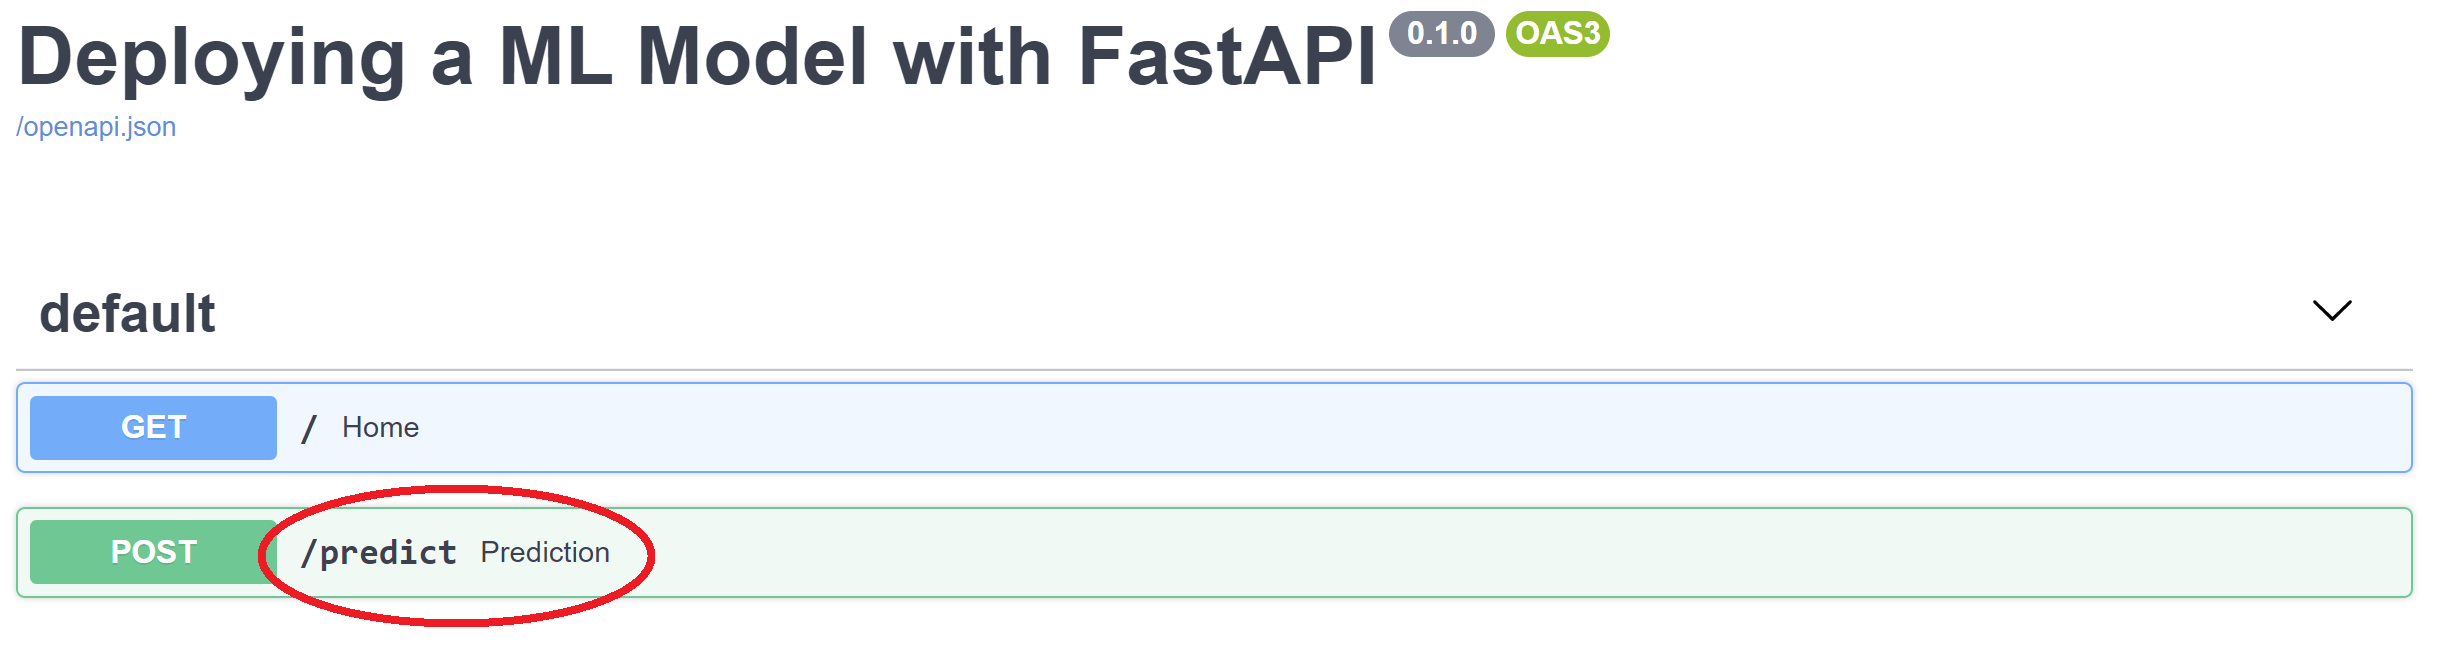



To test your server click on the **Try it out** button.

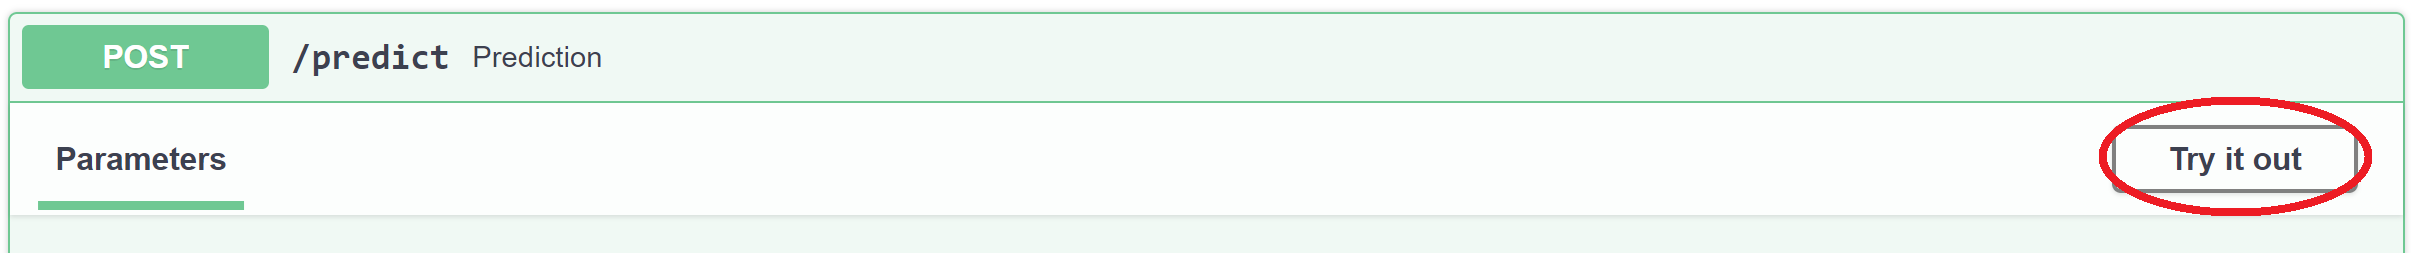

You can choose a model from the **model** field (if you select the full YOLO model the server will be stuck until the weights for this model are downloaded) and a **file** which should be the image in which you want the server to detect objects.

**Submit an image** from your local filesystem by clicking the **Choose File** button, then click on the blue **Execute** button to send an HTTP request to the server. After doing so, **scroll down and you will see the response from it**. Pretty cool, right?

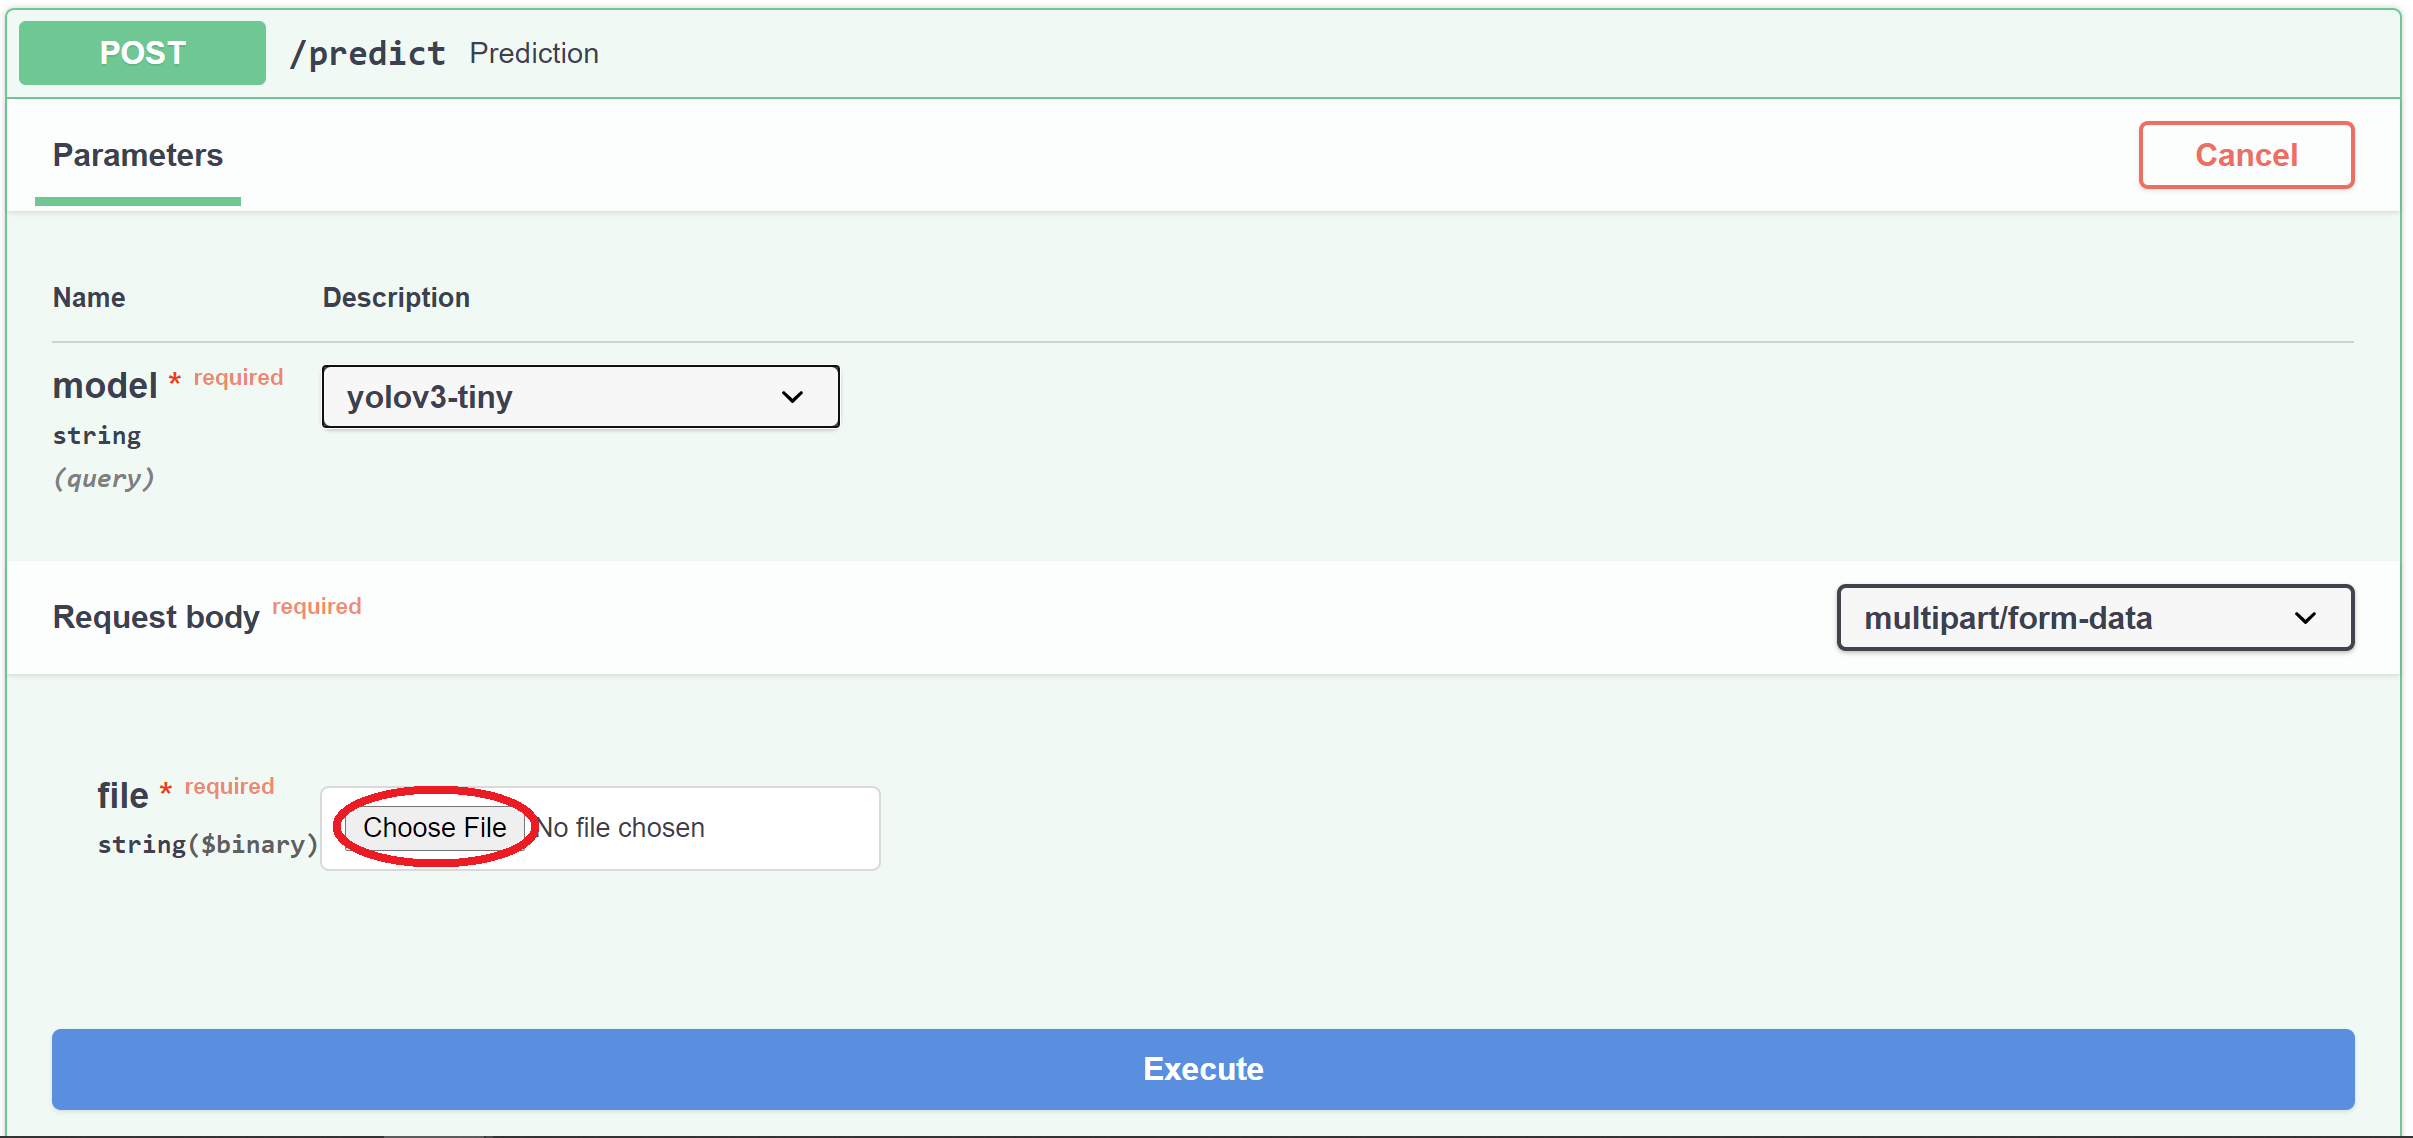

**Try different images!** You can use the ones we provided with this lab or some of your own. Since the model is using the default confidence level of 0.5 it might not always succeed to detect some objects. 

Also, try submitting non-image files and see how the server reacts to it.

## Consuming your model from another client

It is awesome that fastAPI allows you to interact with your API through its built-in client. However, you might wonder how you can interact with your API using regular code and not some UI.

To do so, we have also provided a notebook in which you can check how a minimal client in Python looks like. For this, **leave the server running (don't interrupt the kernel or close this window)** and open the `client.ipynb` notebook. To do so you can open the File Browser tab on the sidebar located on the left of the window and double click on `client.ipynb`. If you cannot see a different tab for each file (which is very useful for moving between them) then it is possible you have the "Simple Interface" (aka Single-Document) mode enabled. To disable it you can go to the View tab and do so.

There is also an optional challenge ahead!